## AMNE 376: A Study of Richter's Kouroi Through Image Embedding

Author: *Kaiyan Zhang, Yash Mali, prAxIs UBC Team*

### 1. Introduction: How Computers See Visual Art?

#### 1.1 Digital Representations of Images

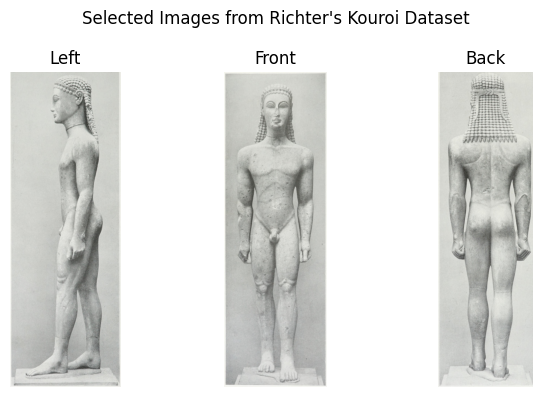

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder path where the images are stored
image_path = '../data/richter_kouroi_filtered_photos' 

fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# List of specific image filenames
image_names = {'page188_img01_photo12.jpg': "Left", 'page188_img01_photo13.jpg': "Front", 'page189_img01_photo3.jpg': "Back"}

# Display the images side by side
axes = axes.flatten()
for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(image_names[img_name])
    axes[i].axis('off')

plt.suptitle("Selected Images from Richter's Kouroi Dataset")
plt.tight_layout()
plt.show()


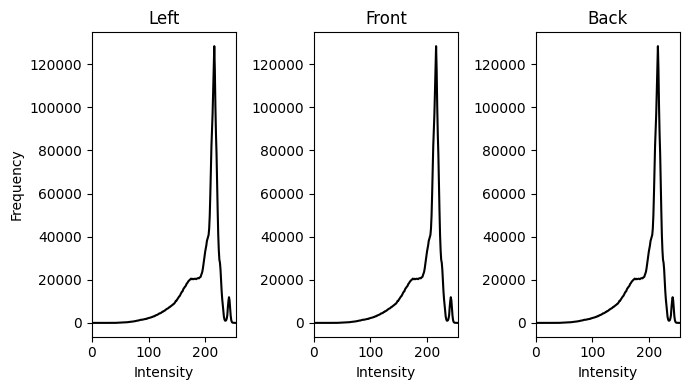

In [41]:
# Generate and plot greyscale histograms for the selected images
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    histogram = image.histogram()

    axes[i].plot(histogram, color='black')
    axes[i].set_title(f'{image_names[img_name]}')
    axes[i].set_xlim([0, 255])
    axes[i].set_xlabel("Intensity")
    if i == 0:
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

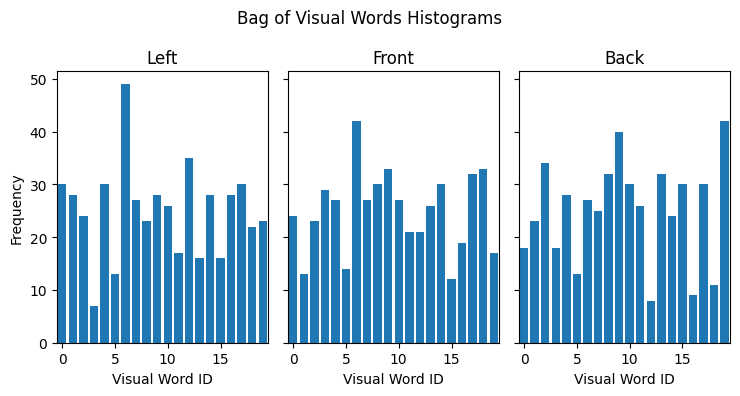

In [3]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Define the number of clusters for KMeans
n_clusters = 20

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=500)
all_descriptors = []
image_data = []

for img_name in image_names:
    img_path = os.path.join(image_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(img, None)

    all_descriptors.append(descriptors)
    
    image_data.append((img_name, descriptors))

# Stack descriptors for clustering
all_descriptors_stacked = np.vstack(all_descriptors)

# Build the visual vocabulary using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors_stacked)

# Compute histogram for each image
histograms = []
for img_name, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters+1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
        
    histograms.append((img_name, hist))
    
fig, axes = plt.subplots(1, len(histograms), figsize=(2.5 * len(histograms), 4), sharey=True)
if len(histograms) == 1:
    axes = [axes]

x = np.arange(n_clusters)
for ax, (img_name, hist) in zip(axes, histograms):
    ax.bar(x, hist)
    ax.set_title(f"{image_names[img_name]}")
    ax.set_xlabel("Visual Word ID")
    ax.set_xlim([-0.5, n_clusters - 0.5])
    if ax is axes[0]:
        ax.set_ylabel("Frequency")

plt.suptitle("Bag of Visual Words Histograms")
plt.tight_layout()
plt.show()

#### 1.2 Measurement of Similarity

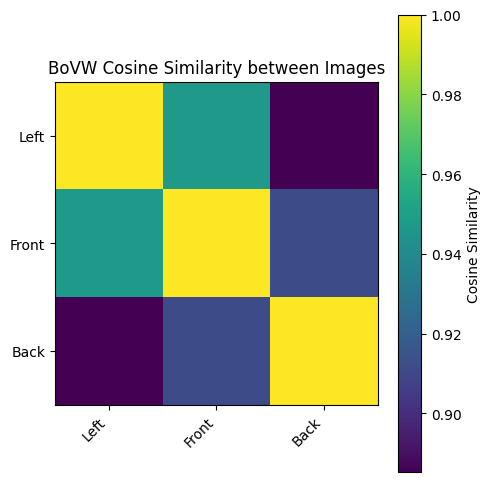

Pairwise Cosine Similarity Matrix:
Left vs Front: 0.947
Left vs Back: 0.885
Front vs Back: 0.912


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

hist_list = []
for img_name, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters + 1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
    hist = hist.astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()
    hist_list.append(hist)
    
histograms = np.array(hist_list)

sim_matrix = cosine_similarity(histograms)

image_keys = list(image_names.keys())
image_labels = list(image_names.values())

# Display the similarity matrix
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(sim_matrix, interpolation='nearest', cmap='viridis')
ax.set_title('BoVW Cosine Similarity between Images')
ax.set_xticks(np.arange(len(image_labels)))
ax.set_yticks(np.arange(len(image_labels)))
ax.set_xticklabels(image_labels, rotation=45, ha='right')
ax.set_yticklabels(image_labels)
fig.colorbar(cax, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

print("Pairwise Cosine Similarity Matrix:")
for i in range(len(image_labels)):
    for j in range(i + 1, len(image_labels)):
        print(f"{image_labels[i]} vs {image_labels[j]}: {sim_matrix[i, j]:.3f}")


Cosine Similarity of 'A Kouroi from Athens' with existing images:
Left vs A Kouroi from Athens: 0.816
Front vs A Kouroi from Athens: 0.892
Back vs A Kouroi from Athens: 0.839


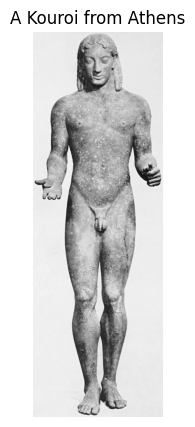

In [45]:
# Define a new image to compare with the existing ones
new_image_path = '../data/richter_kouroi_filtered_photos/page312_img01_photo4.jpg'
new_image_label = 'A Kouroi from Athens' # Suppose this is a new artifact we just discovered

img_new = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten() 

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new, cmap='gray')
plt.title(f"{new_image_label}")
plt.axis('off')
plt.show()



Cosine Similarity of 'A Bronze Figure from Sanxingdui' with existing images:
Left vs A Bronze Figure from Sanxingdui: 0.586
Front vs A Bronze Figure from Sanxingdui: 0.640
Back vs A Bronze Figure from Sanxingdui: 0.638


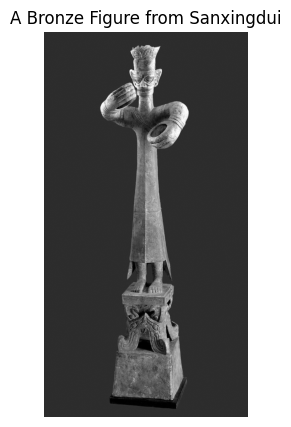

In [44]:
# Define a new image to compare with the existing ones
new_image_path2 = '../data/example_images/sanxingdui.jpeg'
new_image_label2 = 'A Bronze Figure from Sanxingdui' # Suppose this is a new artifact we just discovered

img_new2 = cv2.imread(new_image_path2, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new2, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten()  

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label2}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label2}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new2, cmap='gray')
plt.title(f"{new_image_label2}")
plt.axis('off')
plt.show()

### 2. Data Exploration

#### 2.1 Data Collection and Preprocessing

#### 2.2 Exploring the Metadata

In [ ]:
import pandas as pd

# Read in the metadata CSV file
# Note that we are only going to investigate a subset of the full dataset
df = pd.read_csv('../data/complete_sculpture_dataset_labeled.csv')

df = df.drop(columns = 'page')

print(df.head())

                    filename          group           era material
0  page188_img01_photo13.jpg  SOUNION GROUP  615 - 590 BC   Marble
1   page202_img01_photo3.jpg  SOUNION GROUP  615 - 590 BC   Marble
2   page202_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
3   page205_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
4  page211_img01_photo12.jpg  SOUNION GROUP  615 - 590 BC     Lead


In [43]:
print("Information of the dataset:")
print(f"Number of images: {df.shape[0]}")
print(f"Number of distinct eras: {df['era'].nunique()}")
print(f"Number of distinct materials: {df['material'].nunique()}")

Information of the dataset:
Number of images: 62
Number of distinct eras: 7
Number of distinct materials: 6


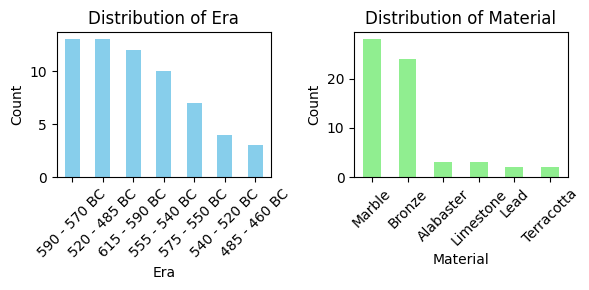

In [ ]:
def bar_plot(df, column1, column2):
    # Calculate counts of each value in the specified columns
    label_counts1 = df[column1].value_counts()
    label_counts2 = df[column2].value_counts()

    # Create a figure with a fixed size
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Plot the bar chart
    label_counts1.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {column1.capitalize()}')
    axes[0].set_xlabel(column1.capitalize())
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    label_counts2.plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Distribution of {column2.capitalize()}')
    axes[1].set_xlabel(column2.capitalize())
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels in the dataset
bar_plot(df, 'era', 'material')

#### 2.3 Exploring the Images

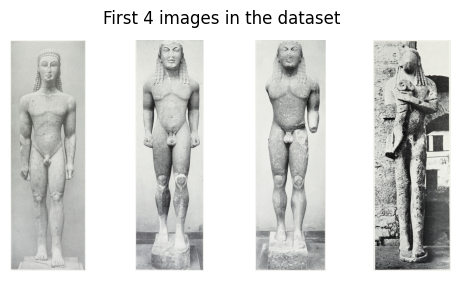

In [48]:
# Read in the images as a list 
from pathlib import Path

data_dir = Path("../data/richter_kouroi_complete_front_only")
image_paths = sorted(data_dir.glob("*.jpg"))

images = []
for p in image_paths:
    img = Image.open(p).convert("RGB")   # ensure 3‑channel
    img_arr = np.array(img)
    images.append(img_arr)
    
fig, axes = plt.subplots(1, 4, figsize=(6, 3))
for ax, img in zip(axes, images[:4]):
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("First 4 images in the dataset")
plt.show()


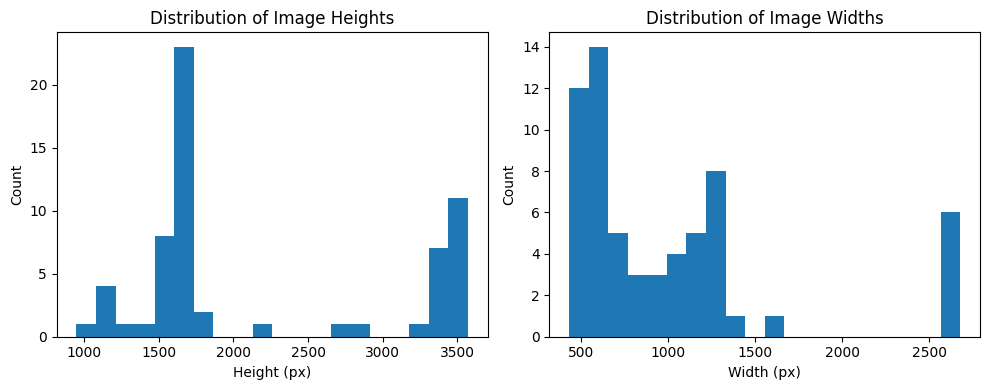

In [51]:
shapes = [img.shape for img in images]
dtypes = set(img.dtype for img in images)

# Histogram of image heights and widths
heights = [s[0] for s in shapes]
widths  = [s[1] for s in shapes]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(heights, bins=20)
ax[0].set_title("Distribution of Image Heights")
ax[0].set_xlabel("Height (px)")
ax[0].set_ylabel("Count")
ax[1].hist(widths, bins=20)
ax[1].set_title("Distribution of Image Widths")
ax[1].set_xlabel("Width (px)")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

### 3. Image Embedding Using ConvNext V2

#### 3.1 CNN and Pre-trained Models

#### 3.2 Creating Image Embeddings

### 4. Analysis of Image Embeddings
#### 4.1 Principal Component Analysis

#### 4.2 TSNE Visualization

#### 4.3 K-Means Clustering

### 5. Example: Classification of Kouroi Textures Based on Image Embedding

### 6. Computational Formalism? Sentiment Analysis and Content Description Using CLIP

### 7. Conclusion

### Key Takeaways

### Reference
1. Richter, G. M. A. (1970). *Kouroi: Archaic Greek youths: A study of the development of the Kouros type in Greek sculpture.* Phaidon. Accessed through Internet Archive <https://archive.org/details/kouroiarchaicgre0000rich>.